In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [2]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [3]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [4]:
# 数据归一化处理
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
mm = MinMaxScaler([-1, 1])
x_data_mm = mm.fit_transform(x_data)
# 数据降维
# pca = PCA(n_components=10) 
# x_data_mm_pca = pca.fit_transform(x_data_mm)
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data_mm,y_data)

In [5]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [6]:
# 重置数据维度
x_train = x_train.reshape(-1,1,x_train.shape[-1])
x_test = x_test.reshape(-1,1,x_test.shape[-1])

In [7]:
# 对类别数据进行onehot编码
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [9]:
# 构建网络
model = Sequential() 
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu', input_dim=x_train.shape[-1], input_length=x_train.shape[1])))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

In [10]:
# 训练网络
epochs = 200 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V7_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/200
24/28 [========================>.....] - ETA: 0s - loss: 0.5864 - accuracy: 0.7070
Epoch 00001: val_accuracy improved from -inf to 0.69438, saving model to BiLSTM_V7_1.h5
28/28 [==============================] - 3s 102ms/step - loss: 0.5744 - accuracy: 0.7164 - val_loss: 0.6592 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 2/200
26/28 [==========================>...] - ETA: 0s - loss: 0.4173 - accuracy: 0.8053
Epoch 00002: val_accuracy did not improve from 0.69438
28/28 [==============================] - 0s 15ms/step - loss: 0.4112 - accuracy: 0.8092 - val_loss: 0.6429 - val_accuracy: 0.6247 - lr: 0.0010
Epoch 3/200
27/28 [===========================>..] - ETA: 0s - loss: 0.2994 - accuracy: 0.8756
Epoch 00003: val_accuracy did not improve from 0.69438
28/28 [==============================] - 0s 13ms/step - loss: 0.2972 - accuracy: 0.8762 - val_loss: 0.6460 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - ETA: 0s - loss: 0.2240 - accuracy:

Epoch 29/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0244 - accuracy: 0.9934
Epoch 00029: val_accuracy did not improve from 0.83371
28/28 [==============================] - 0s 13ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 2.1224 - val_accuracy: 0.6629 - lr: 0.0010
Epoch 30/200
24/28 [========================>.....] - ETA: 0s - loss: 0.0346 - accuracy: 0.9889
Epoch 00030: val_accuracy did not improve from 0.83371
28/28 [==============================] - 0s 17ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.7010 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 31/200
27/28 [===========================>..] - ETA: 0s - loss: 0.0226 - accuracy: 0.9936
Epoch 00031: val_accuracy did not improve from 0.83371

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 0s 15ms/step - loss: 0.0225 - accuracy: 0.9938 - val_loss: 1.6349 - val_accuracy: 0.6966 - lr: 0.0010
Epoch 32/200
25/28 [=================

Epoch 56/200
28/28 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000    
Epoch 00056: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4961 - val_accuracy: 0.9079 - lr: 5.0000e-04
Epoch 57/200
27/28 [===========================>..] - ETA: 0s - loss: 0.0026 - accuracy: 0.9994
Epoch 00057: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.7377 - val_accuracy: 0.8742 - lr: 5.0000e-04
Epoch 58/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00058: val_accuracy did not improve from 0.93258
28/28 [==============================] - 0s 14ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5848 - val_accuracy: 0.8809 - lr: 5.0000e-04
Epoch 59/200
27/28 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    
Ep

Epoch 83/200
23/28 [=======================>......] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 12ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3657 - val_accuracy: 0.8427 - lr: 2.5000e-04
Epoch 84/200
27/28 [===========================>..] - ETA: 0s - loss: 3.8654e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 15ms/step - loss: 3.9321e-04 - accuracy: 1.0000 - val_loss: 1.5140 - val_accuracy: 0.8225 - lr: 2.5000e-04
Epoch 85/200
24/28 [========================>.....] - ETA: 0s - loss: 6.3581e-04 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 15ms/step - loss: 6.3037e-04 - accuracy: 1.0000 - val_loss: 0.6312 - val_accuracy: 0.8966 - lr: 2.5000e-04
Epoch 86/200
28/28 [==============================] - ETA: 0s - loss: 8.8414e-04 - accurac

Epoch 110/200
27/28 [===========================>..] - ETA: 0s - loss: 3.3414e-04 - accuracy: 1.0000 ETA: 0s - loss: 4.4783e-04 - accuracy
Epoch 00110: val_accuracy did not improve from 0.93483
28/28 [==============================] - 1s 20ms/step - loss: 3.3007e-04 - accuracy: 1.0000 - val_loss: 0.5460 - val_accuracy: 0.9191 - lr: 1.2500e-04
Epoch 111/200
26/28 [==========================>...] - ETA: 0s - loss: 3.6280e-04 - accuracy: 1.0000
Epoch 00111: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 16ms/step - loss: 3.5896e-04 - accuracy: 1.0000 - val_loss: 0.5529 - val_accuracy: 0.9146 - lr: 1.2500e-04
Epoch 112/200
28/28 [==============================] - ETA: 0s - loss: 1.7857e-04 - accuracy: 1.0000
Epoch 00112: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 15ms/step - loss: 1.7857e-04 - accuracy: 1.0000 - val_loss: 0.5122 - val_accuracy: 0.9169 - lr: 1.2500e-04
Epoch 113/200
26/28 [====================

25/28 [=========================>....] - ETA: 0s - loss: 5.7537e-04 - accuracy: 1.0000
Epoch 00136: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 16ms/step - loss: 5.4740e-04 - accuracy: 1.0000 - val_loss: 0.3784 - val_accuracy: 0.9303 - lr: 3.1250e-05
Epoch 137/200
25/28 [=========================>....] - ETA: 0s - loss: 2.1024e-04 - accuracy: 1.0000
Epoch 00137: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 16ms/step - loss: 2.0376e-04 - accuracy: 1.0000 - val_loss: 0.3844 - val_accuracy: 0.9326 - lr: 3.1250e-05
Epoch 138/200
24/28 [========================>.....] - ETA: 0s - loss: 2.1358e-04 - accuracy: 1.0000
Epoch 00138: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 2.0247e-04 - accuracy: 1.0000 - val_loss: 0.4115 - val_accuracy: 0.9303 - lr: 3.1250e-05
Epoch 139/200
26/28 [==========================>...] - ETA: 0s - loss: 5.0688e-04 - accuracy:

28/28 [==============================] - 0s 15ms/step - loss: 2.3677e-04 - accuracy: 1.0000 - val_loss: 0.5130 - val_accuracy: 0.9236 - lr: 1.5625e-05
Epoch 163/200
24/28 [========================>.....] - ETA: 0s - loss: 2.8654e-04 - accuracy: 1.0000
Epoch 00163: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 2.6679e-04 - accuracy: 1.0000 - val_loss: 0.5646 - val_accuracy: 0.9146 - lr: 1.5625e-05
Epoch 164/200
25/28 [=========================>....] - ETA: 0s - loss: 5.5985e-04 - accuracy: 1.0000
Epoch 00164: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 5.6037e-04 - accuracy: 1.0000 - val_loss: 0.6319 - val_accuracy: 0.9101 - lr: 1.5625e-05
Epoch 165/200
26/28 [==========================>...] - ETA: 0s - loss: 1.6797e-04 - accuracy: 1.0000
Epoch 00165: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 3.4924e-04 - accu

Epoch 189/200
27/28 [===========================>..] - ETA: 0s - loss: 1.3382e-04 - accuracy: 1.0000
Epoch 00189: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 1.3255e-04 - accuracy: 1.0000 - val_loss: 0.5178 - val_accuracy: 0.9213 - lr: 7.8125e-06
Epoch 190/200
26/28 [==========================>...] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000  
Epoch 00190: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 9.4841e-04 - accuracy: 1.0000 - val_loss: 0.4592 - val_accuracy: 0.9326 - lr: 7.8125e-06
Epoch 191/200
24/28 [========================>.....] - ETA: 0s - loss: 1.2447e-04 - accuracy: 1.0000
Epoch 00191: val_accuracy did not improve from 0.93483
28/28 [==============================] - 0s 14ms/step - loss: 1.4094e-04 - accuracy: 1.0000 - val_loss: 0.4527 - val_accuracy: 0.9281 - lr: 7.8125e-06
Epoch 192/200
23/28 [=======================>......] - ETA: 0s - loss: 2.3312e-04

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


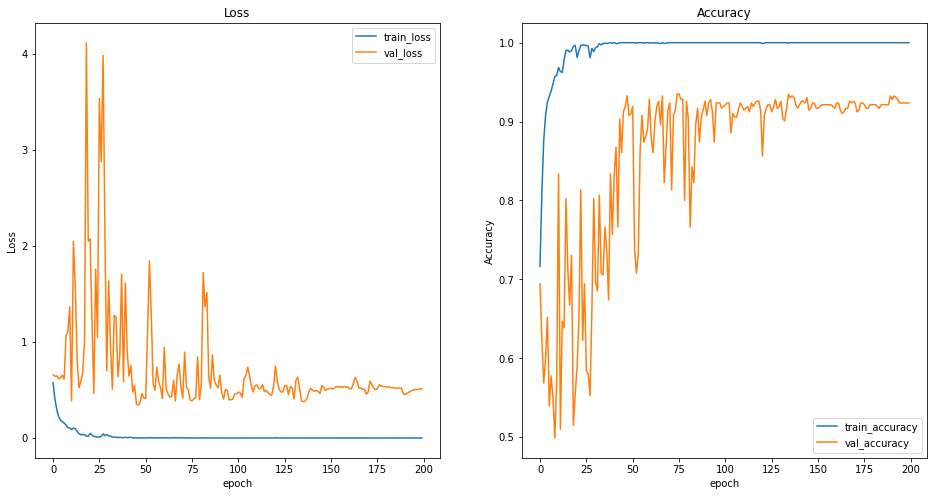

In [11]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [12]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V7_1.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [13]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 0.9994% 召回率:  1.0, f1: 0.9994269340974212
在20%测试集上, accuracy: 0.9348% 召回率: 0.9665271966527197, f1: 0.9409368635437881


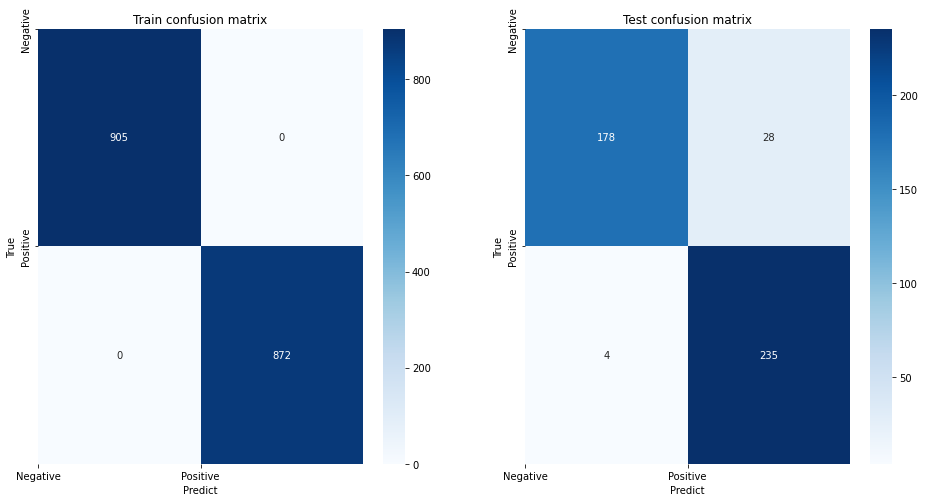

In [66]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()